In [1]:
#==========================#
# Import relevant packages #
#==========================#


import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import erfinv
from iminuit import Minuit
from scipy.stats import chi2
from scipy.stats import binom
%matplotlib inline
from scipy.stats import poisson

## Functions

In [2]:
#——————————————————————————————————————————————————————#
# Find maximum value of the distribution within limits #
#——————————————————————————————————————————————————————#

def find_max(func, low_limit, high_limit, grid=100000):
    x = np.linspace(low_limit, high_limit, num=grid, endpoint=True)
    y = func(x)
    return y.max()

In [3]:
#——————————————————————————————————————————————————#
# A function used to show result of minuit fitting #
#——————————————————————————————————————————————————#
def showIminuitResult(m, init_params):
    #averageList = {}
    valDict = m.values
    errDict = m.errors
    paramNames = list(init_params.keys())
    
    print('\nMinuit fit results are')
    fstr = '{0:8.4f}'
    for pn in paramNames :
        print('   {:15s}'.format(pn), ':  \t', fstr.format(valDict[pn]), ' +/- ', fstr.format(errDict[pn]))
    #averageList.update( { pn : [ valDict[pn], errDict[pn] ] } )
    print('\n')

## Classes

In [4]:
#==================================================================#
# Create an Gaussian class (used to model the signal distribution) #
#==================================================================#


class Gaussian(object):

    #————————————————————————————————————————————————————————#
    # Class constructor | initialize an attribute mass array #
    #————————————————————————————————————————————————————————#

    def __init__(self, mean, sigma, loBound, highBound):
   
        self.loBound = loBound
        self.highBound = highBound
        self.mean = mean
        self.sigma = sigma

        #initialize an mass list used to store mass values
        self.mass = []
    
    
    #——————————————————————————————————#
    # Evaluation method (un-normalize) #
    #——————————————————————————————————#

    def evaluate(self, x):
        return (1/(self.sigma*np.sqrt(2.*np.pi))) * np.exp( -(x-self.mean)**2/(2.*self.sigma**2) )
    

    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrate(self, loBound, highBound):
        integral_result, integral_err = quad(self.evaluate, loBound, highBound)
        return integral_result
    
    
    #————————————————————————————————————————————————————————————————————#
    # Function that generate a single random vars using np.random.normal #
    # method generated var is returned and appended to the mass list     #
    #————————————————————————————————————————————————————————————————————#

    def next(self):
        x = np.random.normal(self.mean, self.sigma, size=1).item()
        self.mass.append(x)
        return x
    

    #——————————————————————————————————————————————————————#
    # A function for setting passed vars as pdf parameters #
    #——————————————————————————————————————————————————————#

    def setParameters(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma

In [5]:
#=========================================================================#
# Create an Exponential class (used to model the background distribution) #
#=========================================================================#


class Exponential(object):
    
    # Constructor
    def __init__(self, loBound, hiBound, decayConst):
        self.loBound = loBound
        self.hiBound = hiBound
        self.decayConst = decayConst
        self.max = find_max(self.evaluate, self.loBound, self.hiBound)
    
    # Set parameters
    def setParameters(self, decayConst):
        self.decayConst = decayConst
    
     # Returns max value of function
    def maxVal(self) :
        return self.max

    # Evaluate method (un-normalised)
    def evaluate(self, t):
        part1 = 1./np.abs(self.decayConst) * np.exp(-t/self.decayConst)
        norm1 =np.exp(-self.loBound/self.decayConst) - np.exp(-self.hiBound/self.decayConst)
        return part1/norm1 

In [6]:
#===========================================================================================#
# Create class that generate a function consisting a Gaussian signal and an exponential bkg #
#===========================================================================================#


class GausSignalWithExpBkg(object):

    #———————————————————#
    # Class constructor #
    #———————————————————#

    def __init__(self, loBound, hiBound, bkgFraction, mean, sigma, decayConst):
        self.bkgFraction = bkgFraction
        self.decayConst = decayConst
        self.loBound = loBound
        self.hiBound = hiBound

        # initialize pdf class to create gaussian signal and an exponential bkg
        self.signal = Gaussian(mean, sigma, self.loBound, self.hiBound)
        self.bkg = Exponential(self.loBound, self.hiBound, decayConst)


    #——————————————————————————————————————————————————————#
    # A function for setting passed vars as pdf parameters #
    #——————————————————————————————————————————————————————#

    def setParameters(self, bkgFraction, mean, sigma, decayConst):
        self.decayConst = decayConst
        self.bkgFraction  = bkgFraction
        self.mean = mean
        self.sigma = sigma


    #——————————————————————————————————#
    # Evaluation method (un-normalize) #
    #——————————————————————————————————#

    def evaluate(self, x):
        return (1-self.bkgFraction)*self.signal.evaluate(x) + self.bkgFraction*self.bkg.evaluate(x)


    #————————————————————————————————————————————————#
    # Evaluate the integral of the pdf within limits #
    #————————————————————————————————————————————————#

    def integrate(self, loBound, highBound):
        integral_result, integral_err = quad(self.evaluate, loBound, highBound)
        return integral_result


In [7]:
#==========================================================================================#
# Create class for negative log-likelihood minimization statistic used for fitting the pdf #
#==========================================================================================#

class NegativeLLcalculator(object):
    
    def __init__(self, pdf, data):
        self.pdf = pdf
        self.data = data


    # function used to update data, mainly for the ability to recycle this class for different fit pdfs
    def updateData( self, data):
        self.data = data

    # Function used to calculate log likelihood
    def calc_neg_LL(self):
        likelihood = self.pdf.evaluate(self.data)/(self.pdf.integrate(self.pdf.loBound, self.pdf.hiBound))
        log_likelihood = np.log(likelihood)
        return -log_likelihood.sum()

    # To calcualte an NLL frm a dataset and a pdf
    def evaluateGausSignalWithExpBkg(self, bkgFraction, mean, sigma, decayConst):
        nll = 0.
        self.pdf.setParameters(bkgFraction, mean, sigma, decayConst)
        
        # here, compute the log likelyhood
        return self.calc_neg_LL()


## Code Execution (Checkpoint 6)

### **Part I**

Begin by plotting the distribution from the data .txt file.

In [8]:
#============================#
# Load in the data .txt file #
#============================#

data_evts = np.loadtxt('datafile-higgs.txt')

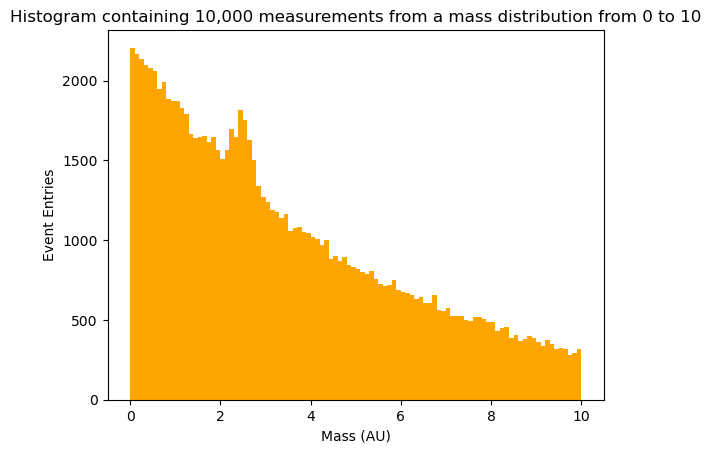

In [9]:
#===================#
# Define Parameters #
#===================#

loBound = 0.
hiBound = 10.
n_bins = 100


#===========================================#
# Plot the data distribution in a histogram #
#===========================================#

plt.hist(data_evts, n_bins, color='orange')
plt.title('Histogram containing 10,000 measurements from a mass distribution from 0 to 10')
plt.xlabel('Mass (AU)')
plt.ylabel('Event Entries')
plt.show()

### **Part I(a)**

The data distribution above contains 10,000 measurements from a mass distribution.

The distribution is described by the following:
- A fraction $F=0.98$ of events from a background exponential  $\sim e^{-(\frac{m}{A})}$ where $A=5$.
- A fraction (signal fraction) $(1-F) =0.02$ of a signal Gaussian. 
- Gaussian mean $M = 2.5$ and width of $\sigma = 0.2$.
- There are only events in the range $[0,10]$.

With the above in mind, in the code below, we try to fit the data distribution with a signal gaussian and an exponential background by using Minuit.

In [10]:
def partI_a():

    # define the parameters
    loBound = 0.
    hiBound = 10.
    # Define fit parameters in a dictionary
    init_params = {
        "bkgFraction":              0.98,
        "mean":                     2.5,
        "sigma":                    0.2,
        "decayConst":               5.,   
    }


    # First initialize the pdf classes for function we use to fit, and the fitting statistics
    pdf = GausSignalWithExpBkg(loBound=loBound, hiBound=hiBound, **init_params)
    fit_stats = NegativeLLcalculator(pdf, data_evts)

    # Initialize iminuit minimizer
    minimizer = Minuit(fit_stats.evaluateGausSignalWithExpBkg, **init_params)
    
    # Set the error difference to 0.5 (we are using NegativeLL)
    minimizer.errordef = 0.5
    
    minimizer.fixed['sigma'] = True

    #Fit for best parameters
    mresult = minimizer.migrad()
    showIminuitResult(minimizer, init_params)
    mresult


In [13]:
# define the parameters
    #loBound = 0.
    #hiBound = 10.
    # Define fit parameters in a dictionary
init_params = {
    "bkgFraction":              0.98,
    "mean":                     2.5,
    "sigma":                    0.2,
    "decayConst":               5.,   
}


    # First initialize the pdf classes for function we use to fit, and the fitting statistics
pdf = GausSignalWithExpBkg(loBound=loBound, hiBound=hiBound, **init_params)
fit_stats = NegativeLLcalculator(pdf, data_evts)

    # Initialize iminuit minimizer
minimizer = Minuit(fit_stats.evaluateGausSignalWithExpBkg, **init_params)
    
    # Set the error difference to 0.5 (we are using NegativeLL)
minimizer.errordef = 0.5
    
minimizer.fixed['sigma'] = True

    #Fit for best parameters
mresult = minimizer.migrad()
showIminuitResult(minimizer, init_params)
mresult


Minuit fit results are
   bkgFraction     :  	   0.9796  +/-    0.0000
   mean            :  	   2.5000  +/-    0.0000
   sigma           :  	   0.2000  +/-    0.0020
   decayConst      :  	   5.0000  +/-    0.0000




┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.146e+05                  │              Nfcn = 147              │
│ EDM = 6.38e-18 (Goal: 0.0001)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name        │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ bkgFraction │ 9.7964e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 1 │ mean        │    2.5    │    0.0    │            │            │         │         │       │
│ 2 │ sigma       │   0.200   │   0.002   │            │            │         │         │  yes  │
│ 3 │ decayConst  │     5     │     0     │            │            │         │         │       │
└───┴─────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘